In [1]:
# Third-party and Standard Libraries
from datetime import datetime
import numpy as np
import torch
import time
import os

# Modules
from KG_test import gpt_test
from KG_precompute import inputs, gram_schmidt1, gram_schmidt2
from KG_train import pinn_train, offline_generation
from KG_data import residual_data
from KG_precompute import q_term,u_term
from H_models import NN

data_dir = "./H_data24"
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)

device = torch.device("cpu")
print_seperator = 60*"*"

alpha    = np.linspace(1.05, 1.95, 11)
beta     = np.linspace( 1.05, 3.95, 11)
gamma    = np.linspace( 1,  1, 1) 
kg_test = np.array(np.meshgrid(alpha, beta, gamma)).T.reshape(-1,3)

In [2]:
params = np.load(data_dir+"/params_gpt_H.npy", allow_pickle=True).item()

xi, xf, ti, tf = params["domain"]["xi"], params["domain"]["xf"], params["domain"]["ti"], params["domain"]["tf"]
Nc = params["data sizes"]["Nc"]
N_test = params["data sizes"]["N_test"]
layers_pinn = params["layers pinn"]
lr_pinn = params["lr pinn"]
epochs_pinn = params["epochs pinn"]
parameter_size = params["parameter size"]
number_of_neurons = params["number of neurons"]
lr_gpt = params[f"lr gpt"]
epochs_gpt_train = params[f"epochs gpt train"]
test_cases = params["test cases"]
epochs_gpt_test = params[f"epochs gpt test"]
sparse = params["sparse"]
seed = params["seed"]

In [3]:
variables = torch.load(data_dir+"/variables_gpt_H.npy", map_location=torch.device('cpu'))

# kg_test = variables["kg_test"]
c_initial = variables["c_initial"]
xt_len = variables["xt_len"]
xt_resid = variables["xt_resid"]
train_out = variables["train_out"]
train_out_xx = variables["train_out_xx"]
train_out_tt = variables["train_out_tt"]
epochs_gpt_train = variables["epochs_gpt_train"]
lr_gpt = variables["lr_gpt"]
out_test = variables["out_test"]

In [18]:
# kg_test = np.loadtxt(data_dir + "/kg_test.dat")
# pinn_test_soln = np.loadtxt(data_dir+"/test_pinn_soln.dat")

print(f"GPT-PINN Testing Started")
test_gpt_time, test_gpt_soln = gpt_test(kg_test,xt_resid,train_out, train_out_xx, train_out_tt, c_initial,
epochs_gpt_train, lr_gpt,train_out)
print(f"GPT-PINN Testing Ended\n")

GPT-PINN Testing Started
GPT-PINN Testing Ended



In [4]:
data_dir_sgpt = "./H_data24d"
variables_sgpt = torch.load(data_dir_sgpt+"/variables_sgpt_H.npy", map_location=torch.device('cpu'))

# kg_test = variables_sgpt["kg_test"]
c_initial_sgpt = variables_sgpt["c_initial"]
xt_len = variables_sgpt["xt_len"]
xt_resid = variables["xt_resid"]
train_out_sgpt = variables_sgpt["train_out"]
train_out_xx_sgpt = variables_sgpt["train_out_xx"]
train_out_tt_sgpt = variables_sgpt["train_out_tt"]
epochs_gpt_train = variables_sgpt["epochs_gpt_train"]
lr_gpt = variables_sgpt["lr_gpt"]
out_test = variables_sgpt["out_test"]
Lhat = variables_sgpt["Lhat"]
X_all_idx = variables_sgpt["X_all_idx"]
out_full = variables_sgpt["out_full"]

In [ ]:
print(f"SGPT-PINN Testing Started")
test_sgpt_time, test_sgpt_soln = gpt_test(kg_test,xt_resid,train_out_sgpt, train_out_xx_sgpt, train_out_tt_sgpt, c_initial_sgpt,
epochs_gpt_train, lr_gpt,out_full,Lhat,X_all_idx)
print(f"SGPT-PINN Testing Ended\n")

In [5]:
num_gpt = 25
epochs_test = 4000 
c_initial_gpt=torch.full((1,num_gpt), 1/(num_gpt)).to(device)
print(f"GPT-PINN Testing Started")
test_gpt_time, test_gpt_soln = gpt_test(kg_test,xt_resid,train_out[:,:num_gpt], train_out_xx[:,:num_gpt], train_out_tt[:,:num_gpt], c_initial_gpt[0],
epochs_test, lr_gpt,train_out[:,:num_gpt])
print(f"GPT-PINN Testing Ended\n")


print(f"SGPT-PINN Testing Started")
test_sgpt_time, test_sgpt_soln = gpt_test(kg_test,xt_resid,train_out_sgpt[:2*num_gpt-1,:num_gpt], train_out_xx_sgpt[:2*num_gpt-1,:num_gpt], train_out_tt_sgpt[:2*num_gpt-1,:num_gpt], c_initial_sgpt[:num_gpt],
epochs_test, lr_gpt,out_full[:,:num_gpt],X_all_idx,X_all_idx[:2*num_gpt-1])
print(f"SGPT-PINN Testing Ended\n")

GPT-PINN Testing Started
GPT-PINN Testing Ended

SGPT-PINN Testing Started
SGPT-PINN Testing Ended



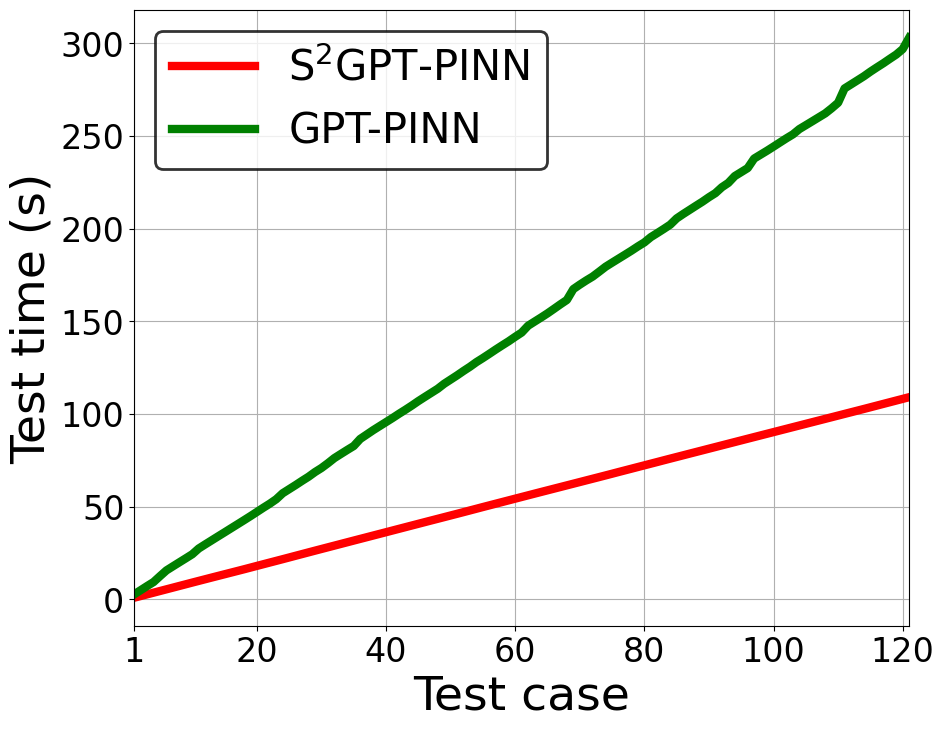

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
x_plt16 = range(1,test_sgpt_time.shape[0]+1) 
x_ticks = list(range(0,test_sgpt_time.shape[0]+1,20))
x_ticks[0] = 1
ax.plot(x_plt16, test_sgpt_time*3600, color="red",   label="S$^2$GPT-PINN", lw=6)
ax.plot(x_plt16, test_gpt_time*3600,  color="green", label="GPT-PINN",  lw=6)
ax.set_xticks(ticks=x_ticks)
ax.set_xlim(min(x_plt16),max(x_plt16))
ax.set_xlabel("Test case", fontsize=34)
ax.set_ylabel("Test time (s)", fontsize=34)
legend = ax.legend(frameon=True, fontsize=30)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', which='major', labelsize=24)
ax.grid()
#plt.yscale('log')
plt.show()

In [185]:
print(test_gpt_time[0],test_sgpt_time[0])

0.0007406167189280192 0.00026120940844217937


In [186]:
np.savetxt(data_dir+f"/test_gpt_soln.dat",   test_gpt_soln)
np.savetxt(data_dir+f"/test_gpt_time.dat",   test_gpt_time)

np.savetxt(data_dir+f"/test_sgpt_soln.dat",   test_sgpt_soln)
np.savetxt(data_dir+f"/test_sgpt_time.dat",   test_sgpt_time)

In [8]:
test_exact_soln = np.zeros((train_out.shape[0], len(kg_test)))
for i, kg_param in enumerate(kg_test):
    alpha, beta, gamma = kg_param

    soln = u_term(xt_resid[:,0].unsqueeze(1), xt_resid[:,1].unsqueeze(1),alpha, beta, gamma)
        
    test_exact_soln[:,i][:,None] = soln.detach().cpu().numpy()

In [93]:
shape= [200,200]
x = xt_resid[:,0].reshape(shape).detach().cpu().numpy()
t = xt_resid[:,1].reshape(shape).detach().cpu().numpy()

index =112 #12
ex_gpt_soln = test_gpt_soln[:,index]
ex_sgpt_soln = test_sgpt_soln[:,index]
ex_pinn_soln = test_exact_soln[:,index]
print(kg_test[index])

[1.95 1.63 1.  ]


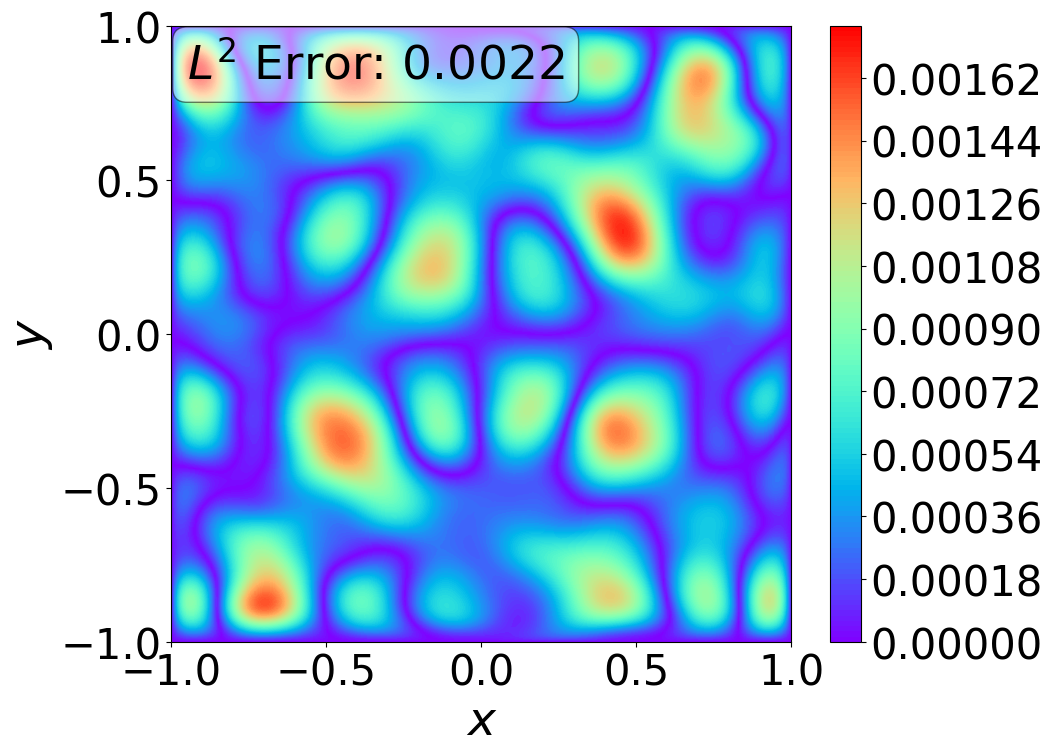

In [94]:
L2 = np.linalg.norm(ex_sgpt_soln - ex_pinn_soln) / np.linalg.norm(ex_pinn_soln)
fig, ax = plt.subplots(figsize=(10,8))
plot = ax.contourf(x, t, abs(ex_sgpt_soln-ex_pinn_soln).reshape(shape), 150, cmap="rainbow")
cbar = fig.colorbar(plot)
cbar.ax.tick_params(labelsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.025, 0.975, f"$L^2$ Error: {round(L2,4)}", transform=ax.transAxes, 
        fontsize=34, verticalalignment='top', bbox=props)
#ax.set_title(fr"Error SGPT-PINN: $\nu={round(test_cases[index,0],2),round(test_cases[index,1],2),round(test_cases[index,2],2)}$", fontsize=25,pad=15)
ax.set_xlabel("$x$", fontsize=34)
ax.set_ylabel("$y$", fontsize=34)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.show()

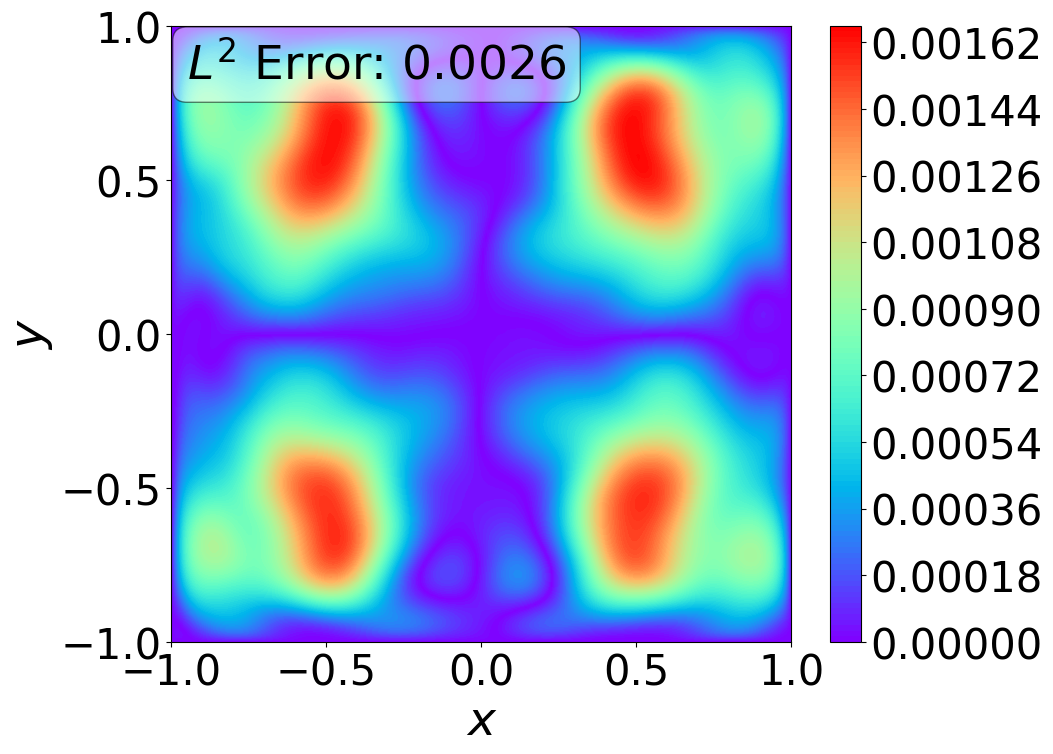

In [95]:
# print(f"GPT-PINN Testing Started")
# test_gpt_time, test_gpt_soln = gpt_test(kg_test,xt_resid,train_out, train_out_xx, train_out_tt, c_initial,
# epochs_gpt_train*10, lr_gpt,train_out)
# print(f"GPT-PINN Testing Ended\n")

L2 = np.linalg.norm(ex_gpt_soln - ex_pinn_soln) / np.linalg.norm(ex_pinn_soln)
fig, ax = plt.subplots(figsize=(10,8))
plot = ax.contourf(x, t, abs(ex_gpt_soln-ex_pinn_soln).reshape(shape), 150, cmap="rainbow")
cbar = fig.colorbar(plot)
cbar.ax.tick_params(labelsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.025, 0.975, f"$L^2$ Error: {round(L2,4)}", transform=ax.transAxes, 
        fontsize=34, verticalalignment='top', bbox=props)
#ax.set_title(fr"Error GPT-PINN: $\nu={round(test_cases[index,0],2),round(test_cases[index,1],2),round(test_cases[index,2],2)}$", fontsize=25,pad=15)
ax.set_xlabel("$x$", fontsize=34)
ax.set_ylabel("$y$", fontsize=34)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.show()

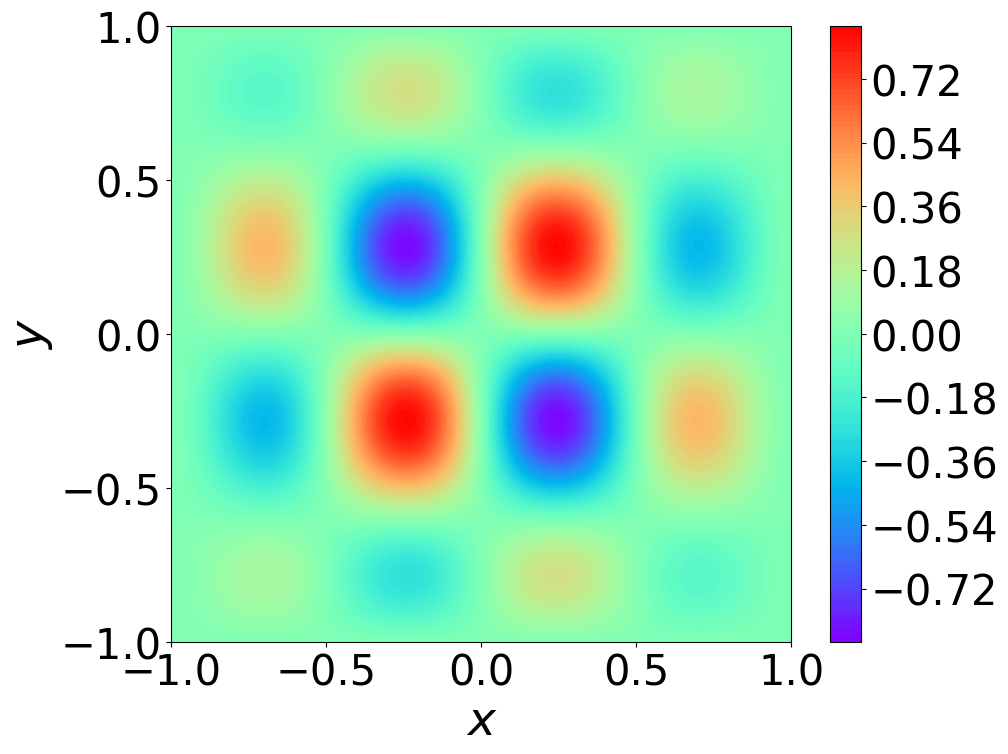

In [96]:
fig, ax = plt.subplots(figsize=(10,8))
plot = ax.contourf(x, t, ex_pinn_soln.reshape(shape), 150, cmap="rainbow")
cbar = fig.colorbar(plot)
cbar.ax.tick_params(labelsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#ax.set_title(fr"Error SGPT-PINN: $\nu={round(test_cases[index,0],2),round(test_cases[index,1],2),round(test_cases[index,2],2)}$", fontsize=25,pad=15)
ax.set_xlabel("$x$", fontsize=34)
ax.set_ylabel("$y$", fontsize=34)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.show()

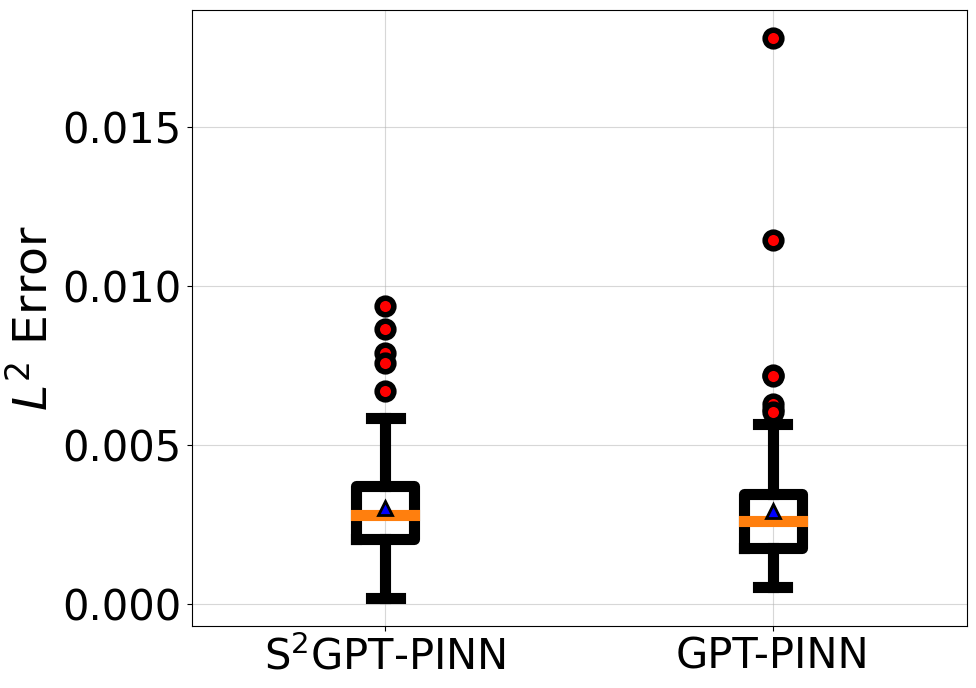

In [97]:
L2_sgpt = np.array([np.linalg.norm(test_sgpt_soln[:,i] - test_exact_soln[:,i]) / np.linalg.norm(test_exact_soln[:,i]) for i in range(test_exact_soln.shape[1])])
L2_gpt  = np.array([np.linalg.norm( test_gpt_soln[:,i] - test_exact_soln[:,i]) / np.linalg.norm(test_exact_soln[:,i]) for i in range(test_exact_soln.shape[1])])

errors = np.hstack((L2_sgpt[:,None], L2_gpt[:,None]))

fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(errors, showmeans=True, boxprops=dict(linewidth=8), 
           whiskerprops=dict(linewidth=8), capprops=dict(linewidth=8),
           medianprops=dict(linewidth=8), meanprops=dict(marker='^',
           markersize=10, markerfacecolor='blue', markeredgecolor='black',
           markeredgewidth=2),
           flierprops=dict(marker='o',  markersize=12, linestyle='none', 
                           markerfacecolor='r', markeredgewidth=4))
ax.grid(alpha=0.5)
ax.set_ylabel("$L^2$ Error", fontsize=34)
ax.set_xticks([1,2], ["S$^2$GPT-PINN", "GPT-PINN"])
ax.tick_params(axis='both', which='major', labelsize=30)
#plt.yscale('log')
plt.show()

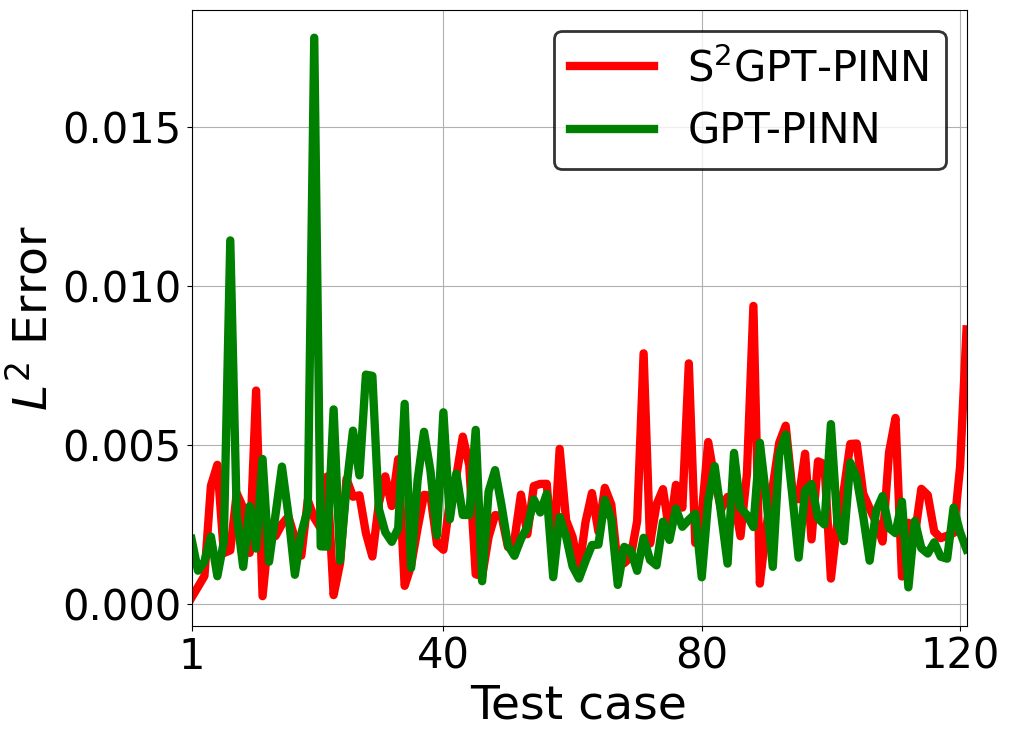

In [98]:
#plot 16
fig, ax = plt.subplots(figsize=(10,8))
x_plt16 = range(1,test_exact_soln.shape[1]+1) 
x_ticks = list(range(0,test_exact_soln.shape[1]+1,40))
x_ticks[0] = 1
ax.plot(x_plt16, L2_sgpt, color="red",   label="S$^2$GPT-PINN", lw=6)
ax.plot(x_plt16, L2_gpt,  color="green", label="GPT-PINN",  lw=6)
ax.set_xticks(ticks=x_ticks)
ax.set_xlim(min(x_plt16),max(x_plt16))
ax.set_xlabel("Test case", fontsize=34)
ax.set_ylabel("$L^2$ Error", fontsize=34)
legend = ax.legend(frameon=True, fontsize=30)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', which='major', labelsize=30)
ax.grid()
#plt.yscale('log')
plt.show()